<a href="https://colab.research.google.com/github/aksjfds/Sepsis-Mortality/blob/main/Sepsis%20Mortality%20code%20file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb

# **Data Preprocessing**

In [9]:
df = pd.read_csv('/content/Data_after_Cleaning.csv')
df = df.iloc[:, 1:]

In [10]:
df.shape

(5208, 48)

In [11]:
df_encoded = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns)
df_dropped = df_encoded.dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             5208 non-null   int64  
 1   hospital_expire_flag                   5208 non-null   int64  
 2   max_age                                5208 non-null   int64  
 3   los_icu                                5208 non-null   float64
 4   first_hosp_stay                        5208 non-null   bool   
 5   suspected_infection                    5208 non-null   int64  
 6   sofa_score                             5208 non-null   int64  
 7   sepsis3                                5208 non-null   bool   
 8   avg_urineoutput                        5208 non-null   float64
 9   glucose_min                            5208 non-null   float64
 10  glucose_max                            5208 non-null   float64
 11  gluc

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             5208 non-null   int64  
 1   hospital_expire_flag                   5208 non-null   int64  
 2   max_age                                5208 non-null   int64  
 3   los_icu                                5208 non-null   float64
 4   first_hosp_stay                        5208 non-null   bool   
 5   suspected_infection                    5208 non-null   int64  
 6   sofa_score                             5208 non-null   int64  
 7   sepsis3                                5208 non-null   bool   
 8   avg_urineoutput                        5208 non-null   float64
 9   glucose_min                            5208 non-null   float64
 10  glucose_max                            5208 non-null   float64
 11  gluc

# **drop duplications**

In [13]:
duplicated_rows_mask = df_dropped['subject_id'].duplicated(keep=False)

# Extract the duplicated rows
duplicated_rows = df_dropped[duplicated_rows_mask]
new_data  = df_dropped.drop_duplicates()
duplicated_rows_mask = new_data['subject_id'].duplicated(keep=False)

# Extract the duplicated rows
duplicated_rows = new_data[duplicated_rows_mask]
# Separate out columns based on data types
int_float_cols = new_data.select_dtypes(include=['int64', 'float64']).columns
uint8_cols = new_data.select_dtypes(include=['uint8']).columns

# Sort dataframe
# For int and float columns: sort in descending order so that larger values come first
df = new_data.sort_values(by=list(int_float_cols), ascending=False)

# For uint8 columns: sort in descending order so that 1 comes before 0
df = df.sort_values(by=list(uint8_cols), ascending=False)

# Drop duplicates based on subject_id, keeping the first (which are the desired rows after sorting)
df_reduced = df.drop_duplicates(subset='subject_id', keep='first')

# Reset index if needed
df_reduced = df_reduced.reset_index(drop=True)
pd.set_option('display.max_columns', None)
df_reduced

,subject_id,hospital_expire_flag,max_age,los_icu,first_hosp_stay,suspected_infection,sofa_score,sepsis3,avg_urineoutput,glucose_min,glucose_max,glucose_average,sodium_max,sodium_min,sodium_average,diabetes_without_cc,diabetes_with_cc,severe_liver_disease,aids,renal_disease,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,spo2_min,spo2_max,spo2_mean,coma,albumin,race_Black or African American,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
0,19997886,0,72,2.00,True,1,5,True,120.882353,123.0,140.0,131.500000,140.0,131.0,135.500000,0,0,1,0,0,81,99,91.708333,82.0,116.0,99.166667,48.0,64.0,57.083333,14.0,27.0,20.125000,93,100,96.375000,1,4.4,0,0,0,1,0,0,0,0,1,0,1
1,19997293,0,76,10.54,True,1,5,True,170.728814,116.0,199.0,157.900000,142.0,129.0,138.300000,1,0,0,0,1,36,112,69.683501,40.0,189.0,111.615385,22.0,119.0,58.724924,9.0,33.0,18.913240,68,100,95.513081,1,1.9,0,0,0,1,1,0,0,0,0,0,1
2,19995127,0,83,2.96,True,1,3,True,331.750000,78.0,108.0,94.500000,141.0,137.0,139.250000,0,0,0,0,0,80,117,96.040741,89.0,145.0,116.160000,50.0,87.0,69.380000,15.0,34.0,21.915556,90,100,96.417778,0,4.1,1,0,0,0,0,0,0,0,1,0,1
3,19994379,0,71,2.92,True,1,6,True,320.833333,80.0,141.0,115.166667,138.0,126.0,132.833333,0,0,0,0,1,67,132,88.354338,69.0,117.0,93.547025,44.0,160.0,63.192259,8.0,30.0,16.663109,86,100,94.621264,0,3.8,0,0,0,1,0,0,0,0,1,0,1
4,19993726,0,52,9.04,True,1,2,True,159.777778,117.0,165.0,141.000000,139.0,137.0,138.000000,0,0,0,0,0,102,146,121.260870,72.5,136.0,101.510417,44.0,74.0,58.354167,12.0,33.0,19.112245,96,100,99.826087,0,2.4,0,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5203,10004720,1,64,5.08,True,1,8,True,46.315789,128.0,182.0,155.000000,136.0,134.0,135.000000,0,0,0,0,0,68,86,73.955556,86.0,154.0,103.415094,47.0,88.0,57.377358,10.0,17.0,14.990741,93,100,98.094340,1,2.5,0,0,0,1,1,0,0,0,0,0,1
5204,10003400,1,75,12.92,True,1,3,True,121.916667,97.0,148.0,113.166667,141.0,128.0,134.000000,0,0,0,0,1,80,156,108.978900,55.0,142.0,102.811850,21.0,109.0,64.808162,12.0,33.0,18.406541,87,100,99.343939,0,2.4,1,0,0,0,1,0,0,0,0,1,0
5205,10002428,0,85,7.00,True,1,4,True,159.242424,93.0,183.0,124.625000,144.0,128.0,135.500000,0,0,0,0,0,67,135,99.623583,48.0,163.0,100.786261,19.0,116.0,54.326280,16.0,34.0,22.675189,73,100,98.395904,0,4.1,0,0,0,1,1,0,0,0,0,1,0
5206,10002155,1,83,6.21,True,1,2,True,154.318182,95.0,235.0,137.333333,140.0,120.0,132.500000,0,0,0,0,1,65,142,91.539722,66.0,135.0,106.397876,23.0,70.0,50.366830,10.0,37.0,17.472500,80,100,94.055833,0,3.6,0,0,0,1,1,0,0,0,0,1,0


# **Model Training**

In [14]:
X = df_reduced.drop(columns=['hospital_expire_flag','subject_id','first_hosp_stay','suspected_infection','sepsis3'])
y = df_reduced['hospital_expire_flag']

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
count_of_ones = y.sum()

count_of_ones

np.int64(1203)

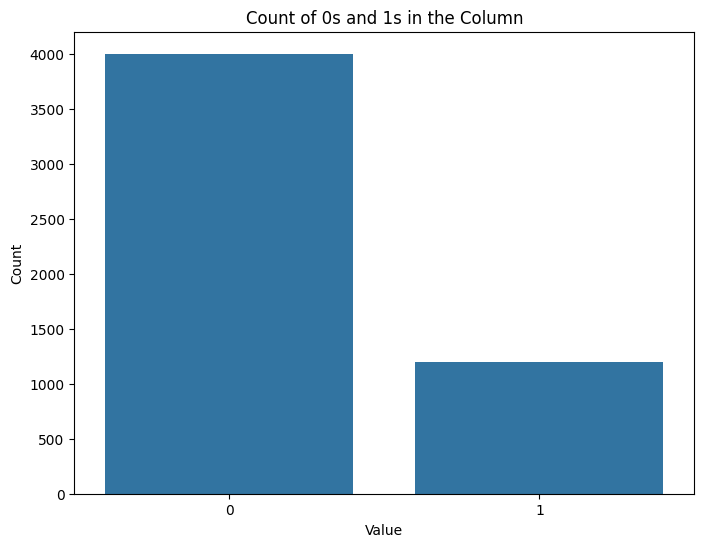

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y' is your column and 'df' is your DataFrame
total_rows = len(df_reduced)
count_of_ones = y.sum()
count_of_zeros = total_rows - count_of_ones

# Preparing data for the bar chart
data = {'Count': [count_of_zeros, count_of_ones], 'Value': ['0', '1']}

# Creating the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Value', y='Count', data=data)
plt.title('Count of 0s and 1s in the Column')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()


In [18]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

classifiers = {
    'SVC': SVC(probability=True, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'XGB': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42)
}

In [19]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    return 5 * (precision * recall) / ((4 * precision) + recall)

# Iterating through each classifier
for name, clf in classifiers.items():
    # Fit model
    clf.fit(X_train, y_train)

    # Predict probabilities and labels
    y_scores_test = clf.predict_proba(X_test)[:, 1]
    y_pred_binary = (y_scores_test > 0.5).astype(int)

    # Calculate metrics
    auc_test = roc_auc_score(y_test, y_scores_test)
    accuracy_test = accuracy_score(y_test, y_pred_binary)
    f1_test = f1_score(y_test, y_pred_binary)
    precision_test = precision_score(y_test, y_pred_binary)
    recall_test = recall_score(y_test, y_pred_binary)
    f2_test = f2_score(precision_test, recall_test)

    # Print results
    print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
          f"F1 Score = {f1_test:.4f}, Precision = {precision_test:.4f}, "
          f"Recall = {recall_test:.4f}, F2 Score = {f2_test:.4f}")

SVC: Test AUC = 0.7057, Test Accuracy = 0.6436, F1 Score = 0.6407, Precision = 0.6307, Recall = 0.6509, F2 Score = 0.6468
DecisionTree: Test AUC = 0.7421, Test Accuracy = 0.7416, F1 Score = 0.7432, Precision = 0.7217, Recall = 0.7660, F2 Score = 0.7567
RandomForest: Test AUC = 0.9377, Test Accuracy = 0.8658, F1 Score = 0.8562, Precision = 0.8976, Recall = 0.8184, F2 Score = 0.8331
GradientBoosting: Test AUC = 0.8888, Test Accuracy = 0.8040, F1 Score = 0.7813, Precision = 0.8578, Recall = 0.7174, F2 Score = 0.7417
MLP: Test AUC = 0.8660, Test Accuracy = 0.7640, F1 Score = 0.7038, Precision = 0.9089, Recall = 0.5742, F2 Score = 0.6198
XGB: Test AUC = 0.9178, Test Accuracy = 0.8427, F1 Score = 0.8316, Precision = 0.8711, Recall = 0.7954, F2 Score = 0.8095
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3223, number of negative: 3185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

def f2_score(precision, recall):
    return 5 * (precision * recall) / ((4 * precision) + recall)

# Iterating through each classifier
for name, clf in classifiers.items():
    # Fit model on training data
    clf.fit(X_train, y_train)

    # Predict probabilities and labels for both train and test datasets
    y_scores_train = clf.predict_proba(X_train)[:, 1]
    y_pred_binary_train = (y_scores_train > 0.5).astype(int)

    y_scores_test = clf.predict_proba(X_test)[:, 1]
    y_pred_binary_test = (y_scores_test > 0.5).astype(int)

    # Calculate metrics for train dataset
    auc_train = roc_auc_score(y_train, y_scores_train)
    accuracy_train = accuracy_score(y_train, y_pred_binary_train)
    f1_train = f1_score(y_train, y_pred_binary_train)
    precision_train = precision_score(y_train, y_pred_binary_train)
    recall_train = recall_score(y_train, y_pred_binary_train)
    sensitivity_train = recall_train  # Sensitivity is the same as Recall
    f2_train = f2_score(precision_train, recall_train)

    # Calculate metrics for test dataset
    auc_test = roc_auc_score(y_test, y_scores_test)
    accuracy_test = accuracy_score(y_test, y_pred_binary_test)
    f1_test = f1_score(y_test, y_pred_binary_test)
    precision_test = precision_score(y_test, y_pred_binary_test)
    recall_test = recall_score(y_test, y_pred_binary_test)
    sensitivity_test = recall_test  # Sensitivity is the same as Recall
    f2_test = f2_score(precision_test, recall_test)

    # Print results for both train and test datasets
    print(f"{name}: Train AUC = {auc_train:.4f}, Train Accuracy = {accuracy_train:.4f}, "
          f"Train F1 Score = {f1_train:.4f}, Train Precision = {precision_train:.4f}, "
          f"Train Recall = {recall_train:.4f}, Train Sensitivity = {sensitivity_train:.4f}, Train F2 Score = {f2_train:.4f}")

    print(f"{name}: Test AUC = {auc_test:.4f}, Test Accuracy = {accuracy_test:.4f}, "
          f"Test F1 Score = {f1_test:.4f}, Test Precision = {precision_test:.4f}, "
          f"Test Recall = {recall_test:.4f}, Test Sensitivity = {sensitivity_test:.4f}, Test F2 Score = {f2_test:.4f}")




SVC: Train AUC = 0.7115, Train Accuracy = 0.6489, Train F1 Score = 0.6535, Train Precision = 0.6487, Train Recall = 0.6584, Train Sensitivity = 0.6584, Train F2 Score = 0.6564
SVC: Test AUC = 0.7057, Test Accuracy = 0.6436, Test F1 Score = 0.6407, Test Precision = 0.6307, Test Recall = 0.6509, Test Sensitivity = 0.6509, Test F2 Score = 0.6468
DecisionTree: Train AUC = 1.0000, Train Accuracy = 1.0000, Train F1 Score = 1.0000, Train Precision = 1.0000, Train Recall = 1.0000, Train Sensitivity = 1.0000, Train F2 Score = 1.0000
DecisionTree: Test AUC = 0.7421, Test Accuracy = 0.7416, Test F1 Score = 0.7432, Test Precision = 0.7217, Test Recall = 0.7660, Test Sensitivity = 0.7660, Test F2 Score = 0.7567
RandomForest: Train AUC = 1.0000, Train Accuracy = 1.0000, Train F1 Score = 1.0000, Train Precision = 1.0000, Train Recall = 1.0000, Train Sensitivity = 1.0000, Train F2 Score = 1.0000
RandomForest: Test AUC = 0.9377, Test Accuracy = 0.8658, Test F1 Score = 0.8562, Test Precision = 0.8976, T

# **AUC & ROC**

In [21]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
import numpy as np

num_folds = 5  # Reduced number of folds for faster execution
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Select five specific models
selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

results = {}
for name, clf in selected_classifiers.items():
    scores = cross_validate(clf, X_smote, y_smote, cv=kf, scoring={'auc': auc_scorer}, n_jobs=-1)
    results[name] = {'AUC': np.mean(scores['test_auc'])}

# Print results
for name, metrics in results.items():
    print(f"{name}: AUC = {metrics['AUC']:.4f}")

SVC: AUC = nan
DecisionTree: AUC = nan
RandomForest: AUC = nan
GradientBoosting: AUC = nan
XGB: AUC = nan
MLP: AUC = nan
LGBM: AUC = nan


***Confidence Interval***

In [22]:
from scipy.stats import sem, t
from sklearn.model_selection import cross_val_score
import numpy as np

confidence_level = 0.95
degrees_freedom = 5 - 1  # degrees of freedom for t-distribution
t_critical = t.ppf((1 + confidence_level) / 2, degrees_freedom)  # t-critical value for 95% CI

results_with_confidence_interval = {}

for name, clf in selected_classifiers.items():
    # Get cross-validated scores for each metric
    auc_scores = cross_val_score(clf, X_smote, y_smote, cv=kf, scoring=auc_scorer, n_jobs=-1)


    # Calculate means
    auc_mean = np.mean(auc_scores)


    # Calculate standard errors
    auc_sem = sem(auc_scores)

    # Calculate confidence intervals
    auc_conf_interval = (auc_mean - t_critical * auc_sem, auc_mean + t_critical * auc_sem)
    # acc_conf_interval = (acc_mean - t_critical * acc_sem, acc_mean + t_critical * acc_sem)

    # Store the results
    results_with_confidence_interval[name] = {
        'AUC Mean': auc_mean,
        'AUC 95% CI': auc_conf_interval
        # 'Accuracy Mean': acc_mean,
        # 'Accuracy 95% CI': acc_conf_interval
    }

# Print the results with confidence intervals
for name, metrics in results_with_confidence_interval.items():
    print(f"{name}: AUC = {metrics['AUC Mean']:.4f} (95% CI: {metrics['AUC 95% CI']})")
    # print(f"{name}: Accuracy = {metrics['Accuracy Mean']:.4f} (95% CI: {metrics['Accuracy 95% CI']})")


SVC: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
DecisionTree: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
RandomForest: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
GradientBoosting: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
XGB: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
MLP: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))
LGBM: AUC = nan (95% CI: (np.float64(nan), np.float64(nan)))


***visualization***

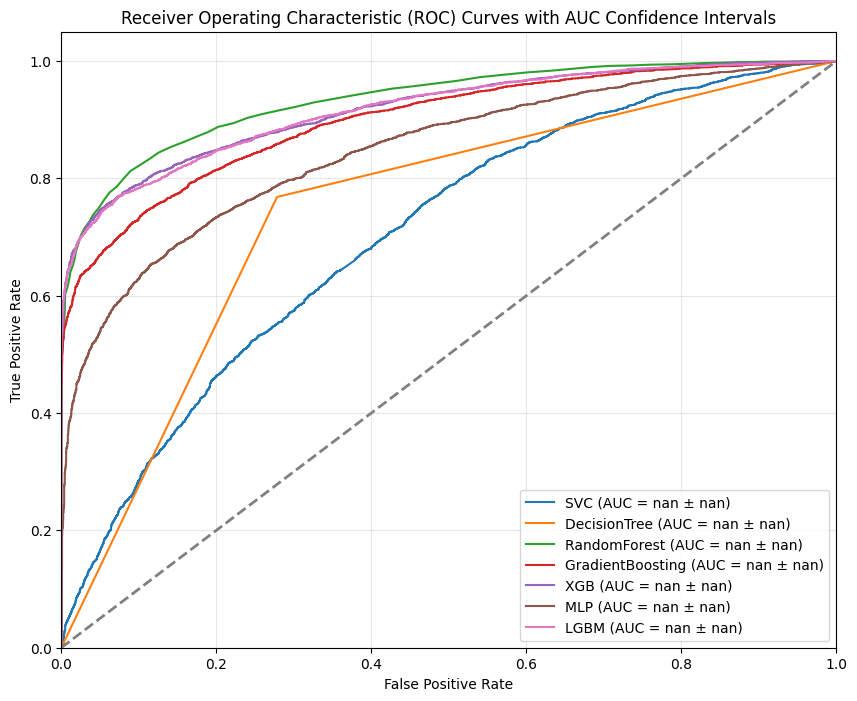

In [23]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

# Define a dictionary to store ROC curve data for each classifier
roc_curves = {}

# Loop through selected classifiers
for name, clf in selected_classifiers.items():
    # Perform cross-validation and get predicted probabilities
    y_scores = cross_val_predict(clf, X_smote, y_smote, cv=kf, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_smote, y_scores)
    roc_auc = auc(fpr, tpr)

    # Store ROC curve data in the dictionary
    roc_curves[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

plt.figure(figsize=(10, 8))

for name, roc_curve_data in roc_curves.items():
    fpr, tpr, roc_auc = roc_curve_data['fpr'], roc_curve_data['tpr'], roc_curve_data['roc_auc']
    mean_auc = results_with_confidence_interval[name]['AUC Mean']
    lower, upper = results_with_confidence_interval[name]['AUC 95% CI']

    # Modify the label string to include AUC and confidence interval
    label = f'{name} (AUC = {mean_auc:.2f} ± {upper - lower:.2f})'

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=label)



# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves with AUC Confidence Intervals')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


SVC: CV AUC Mean = 0.6993, CV Accuracy Mean = 0.6403, CV F1 Score Mean = 0.6432, CV Precision Mean = 0.6418, CV Recall Mean = 0.6447, CV Sensitivity Mean = 0.6447
DecisionTree: CV AUC Mean = 0.7379, CV Accuracy Mean = 0.7380, CV F1 Score Mean = 0.7435, CV Precision Mean = 0.7323, CV Recall Mean = 0.7552, CV Sensitivity Mean = 0.7552
RandomForest: CV AUC Mean = 0.9270, CV Accuracy Mean = 0.8477, CV F1 Score Mean = 0.8430, CV Precision Mean = 0.8754, CV Recall Mean = 0.8129, CV Sensitivity Mean = 0.8129
GradientBoosting: CV AUC Mean = 0.8958, CV Accuracy Mean = 0.8104, CV F1 Score Mean = 0.7985, CV Precision Mean = 0.8578, CV Recall Mean = 0.7468, CV Sensitivity Mean = 0.7468
XGB: CV AUC Mean = 0.9142, CV Accuracy Mean = 0.8400, CV F1 Score Mean = 0.8341, CV Precision Mean = 0.8720, CV Recall Mean = 0.7993, CV Sensitivity Mean = 0.7993
MLP: CV AUC Mean = 0.8478, CV Accuracy Mean = 0.7572, CV F1 Score Mean = 0.7675, CV Precision Mean = 0.7403, CV Recall Mean = 0.7968, CV Sensitivity Mean 

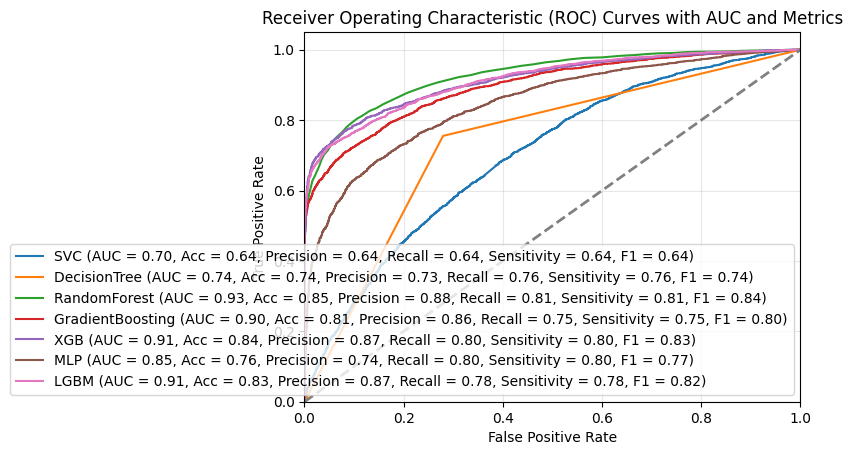

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

selected_classifiers = {
    'SVC': classifiers['SVC'],
    'DecisionTree' : classifiers['DecisionTree'],
    'RandomForest': classifiers['RandomForest'],
    'GradientBoosting': classifiers['GradientBoosting'],
    'XGB': classifiers['XGB'],
    'MLP': classifiers['MLP'],
    'LGBM': classifiers['LGBM']
}

# Define a dictionary to store ROC curve data and other metrics for each classifier
roc_curves_and_metrics = {}

# Loop through selected classifiers
for name, clf in selected_classifiers.items():
    # Perform cross-validation and get predicted probabilities
    y_scores_cv = cross_val_predict(clf, X_train, y_train, cv=kf, method='predict_proba', n_jobs=-1)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_train, y_scores_cv)
    roc_auc = auc(fpr, tpr)

    # Calculate other metrics
    y_pred_cv = (y_scores_cv > 0.5).astype(int)
    accuracy_mean_cv = accuracy_score(y_train, y_pred_cv)
    precision_mean_cv = precision_score(y_train, y_pred_cv)
    recall_mean_cv = recall_score(y_train, y_pred_cv)
    sensitivity_mean_cv = recall_mean_cv  # Sensitivity is the same as Recall
    f1_mean_cv = f1_score(y_train, y_pred_cv)

    # Store ROC curve data and metrics in the dictionary
    roc_curves_and_metrics[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'accuracy_mean_cv': accuracy_mean_cv,
        'precision_mean_cv': precision_mean_cv,
        'recall_mean_cv': recall_mean_cv,
        'sensitivity_mean_cv': sensitivity_mean_cv,
        'f1_mean_cv': f1_mean_cv
    }

# Print cross-validation results
for name, data in roc_curves_and_metrics.items():
    fpr, tpr, roc_auc = data['fpr'], data['tpr'], data['roc_auc']
    accuracy_mean_cv, precision_mean_cv, recall_mean_cv, sensitivity_mean_cv, f1_mean_cv = data['accuracy_mean_cv'], data['precision_mean_cv'], data['recall_mean_cv'], data['sensitivity_mean_cv'], data['f1_mean_cv']

    # Modify the label string to include AUC and other metrics
    label = f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy_mean_cv:.2f}, Precision = {precision_mean_cv:.2f}, Recall = {recall_mean_cv:.2f}, Sensitivity = {sensitivity_mean_cv:.2f}, F1 = {f1_mean_cv:.2f})'

    # Plot the ROC curve (optional, can be removed if not needed)
    plt.plot(fpr, tpr, label=label)

    # Print metrics for cross-validation
    print(f"{name}: CV AUC Mean = {roc_auc:.4f}, "
          f"CV Accuracy Mean = {accuracy_mean_cv:.4f}, "
          f"CV F1 Score Mean = {f1_mean_cv:.4f}, "
          f"CV Precision Mean = {precision_mean_cv:.4f}, "
          f"CV Recall Mean = {recall_mean_cv:.4f}, "
          f"CV Sensitivity Mean = {sensitivity_mean_cv:.4f}")

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves with AUC and Metrics')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **Feature Importance & SHAP Value**

***Feature Importance using best model***

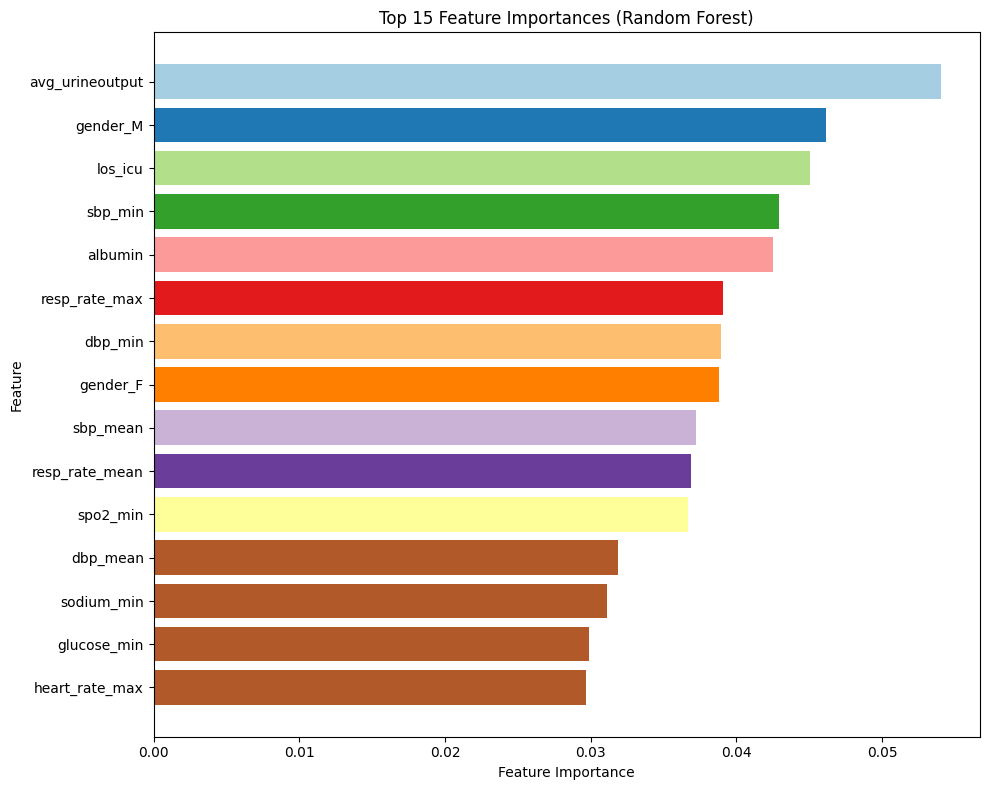

In [25]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to your data (replace X_smote and y_smote with your data)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of the features (replace feature_names with your actual feature names)
feature_names = X_train.columns  # Replace with your feature names

# Sort feature importances and feature names in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx][:15]  # Select the top 15 feature importances
sorted_feature_names = [feature_names[i] for i in sorted_idx][:15]  # Select the corresponding feature names

# Create a vertical bar plot with different colors for each feature
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_names)), sorted_feature_importances, color=plt.cm.Paired(np.arange(len(sorted_feature_names))))
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

***SHAP Method***

In [26]:
model = classifiers['RandomForest'].fit(X_smote, y_smote)

In [27]:
pip install SHAP

In [28]:
import shap

In [29]:
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 1603it [12:32,  2.13it/s]


In [30]:
X_test

,max_age,los_icu,sofa_score,avg_urineoutput,glucose_min,glucose_max,glucose_average,sodium_max,sodium_min,sodium_average,diabetes_without_cc,diabetes_with_cc,severe_liver_disease,aids,renal_disease,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,spo2_min,spo2_max,spo2_mean,coma,albumin,race_Black or African American,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
554,67,58.130000,3,65.340426,131.000000,216.000000,173.500000,147.000000,135.000000,141.000000,0,0,0,0,0,68,133,96.057143,72.000000,165.500000,115.567568,55.000000,104.500000,77.918919,8.000000,23.000000,15.805556,55,100,91.230769,0,1.700000,0,0,0,1,1,0,0,0,0,0,1
6780,58,2.225224,7,5.453718,67.859743,117.674616,89.807500,134.546282,127.650769,132.017179,0,0,0,0,1,63,96,76.627738,75.116410,165.197051,107.966311,23.871666,93.244744,61.041112,7.883590,36.011923,16.299340,93,100,98.679110,0,3.577910,0,0,0,0,1,0,0,0,0,0,1
3101,74,3.500000,3,69.703704,196.000000,348.000000,272.000000,136.000000,129.000000,132.500000,0,0,0,0,1,64,94,83.880000,79.000000,121.000000,101.480000,42.000000,80.000000,65.280000,11.000000,22.000000,16.080000,98,100,99.600000,0,3.600000,0,1,0,0,1,0,0,0,0,0,1
7048,71,1.395527,7,85.484910,90.623129,265.201020,156.526361,143.532653,132.778911,137.128146,0,0,0,0,0,78,139,104.191772,79.311564,142.000000,106.842051,42.422109,89.311564,58.452686,9.000000,32.643198,21.962225,88,100,97.259014,0,3.131156,0,0,0,1,1,0,0,0,0,0,1
2605,50,9.710000,2,207.244898,91.000000,93.000000,92.000000,146.000000,141.000000,143.500000,0,0,0,0,0,63,97,79.888889,117.000000,146.000000,134.560000,70.000000,117.000000,79.600000,14.000000,26.000000,18.850000,94,100,97.185185,0,4.000000,0,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,65,1.080000,4,113.230769,54.000000,724.000000,374.500000,145.000000,135.000000,139.000000,0,1,0,0,0,70,103,90.865217,64.000000,133.000000,102.773411,22.000000,82.000000,42.308110,12.000000,52.000000,17.249612,76,100,98.020833,1,3.600000,0,0,0,1,1,0,0,0,0,1,0
1966,49,14.630000,2,377.741379,118.000000,137.000000,127.500000,146.000000,142.000000,144.000000,0,0,0,0,0,45,66,54.138889,106.000000,173.000000,133.621622,51.000000,82.500000,62.283784,10.000000,22.000000,15.076923,96,100,98.805556,1,2.700000,0,0,1,0,1,0,0,0,0,0,1
6045,87,1.979859,2,114.614381,74.095393,145.973984,102.035772,147.026016,136.000000,140.224282,0,0,0,0,0,66,130,87.819593,69.043360,174.930623,111.511272,28.060705,143.930623,62.368172,12.973984,38.991328,21.406525,83,100,96.971729,0,3.803469,0,0,0,0,1,0,0,0,0,1,0
1079,57,3.630000,2,166.521739,123.000000,242.000000,182.500000,140.000000,137.000000,138.500000,0,0,0,0,0,101,131,116.260000,78.000000,135.000000,99.000000,47.000000,78.000000,60.260000,10.000000,24.000000,17.088235,94,100,98.673469,0,4.700000,0,0,0,1,1,0,0,0,0,1,0


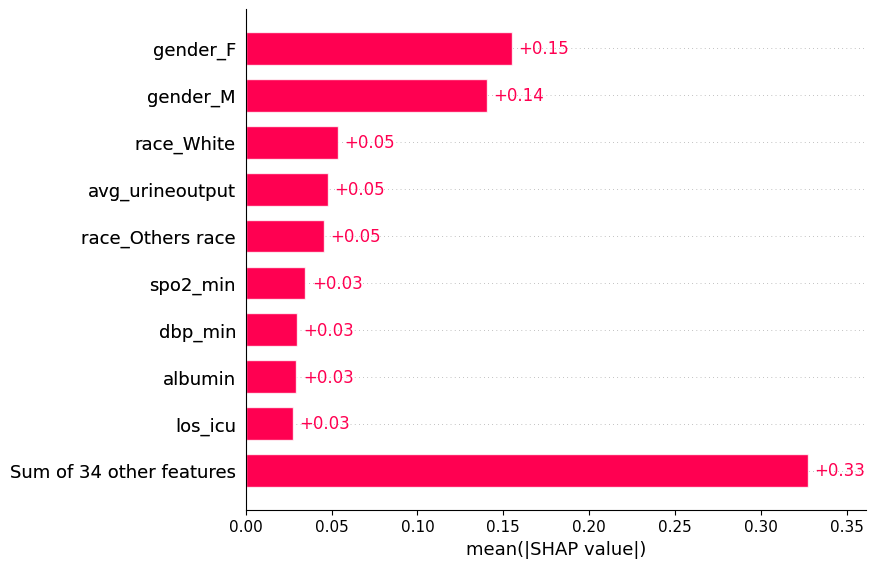

In [31]:
shap.plots.bar(shap_values)

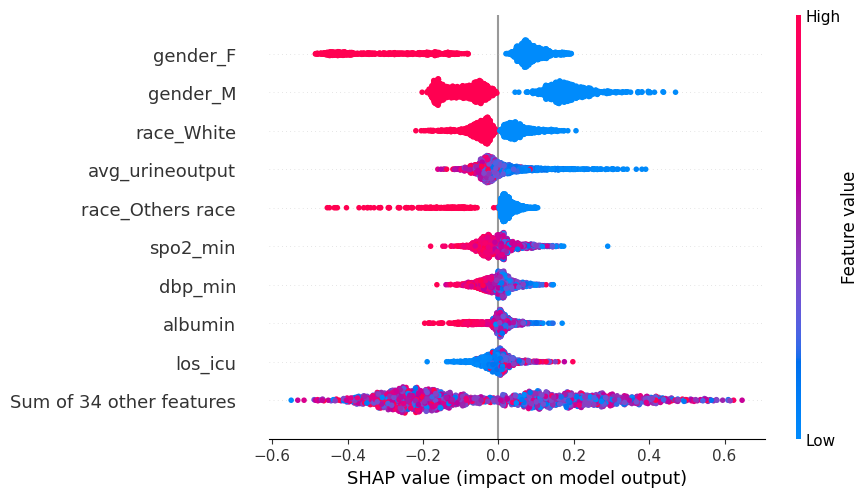

In [32]:

shap.plots.beeswarm(shap_values)

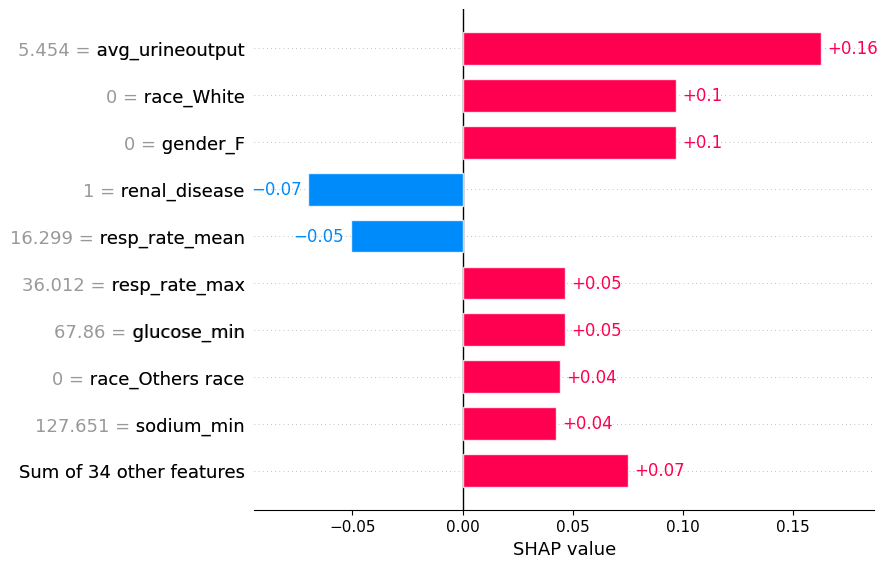

In [33]:
shap.plots.bar(shap_values[1])

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

# Assuming df_reduced is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(df_reduced, test_size=0.2)  # For example, 80% training, 20% test

# Select the numeric columns you want to compare
numeric_cols = [
    'los_icu', 'max_age', 'sofa_score', 'avg_urineoutput', 'temperature_min',
    'temperature_max', 'temperature_avg', 'glucose_min', 'glucose_max',
    'glucose_average', 'sodium_min', 'sodium_max', 'sodium_average',
    'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min',
    'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'resp_rate_min',
    'resp_rate_max', 'resp_rate_mean', 'spo2_min', 'spo2_max', 'spo2_mean'
]

# Initialize a DataFrame to store p-values and means
comparison = pd.DataFrame(index=numeric_cols, columns=['Train Mean', 'Test Mean', 'P-Value'])

# Calculate p-values and means for each variable between train and test sets
for col in numeric_cols:
    train_mean = train[col].dropna().mean()
    test_mean = test[col].dropna().mean()
    p_value = stats.ttest_ind(train[col].dropna(), test[col].dropna(), equal_var=False).pvalue

    comparison.loc[col, 'Train Mean'] = train_mean
    comparison.loc[col, 'Test Mean'] = test_mean
    comparison.loc[col, 'P-Value'] = p_value

# Print the resulting DataFrame with means and p-values
print(comparison)


KeyError: 'temperature_min'

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

# Assuming df_reduced is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(df_reduced, test_size=0.2)  # For example, 80% training, 20% test

# Select the categorical columns you want to compare
categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids',
    'renal_disease','antibiotic_Carbapenem','antibiotic_Aminoglycoside',
    'antibiotic_Glycopeptide','antibiotic_Oxazolidinone','antibiotic_Penicillin',
    'antibiotic_Sulfonamide','antibiotic_Tetracycline','gender_F'
]

# Initialize a DataFrame to store Chi-Square p-values and percentage of ones
comparison = pd.DataFrame(index=categorical_cols, columns=['Chi-Square P-Value', 'Percentage of Ones'])

# Calculate Chi-Square p-values and percentage of ones for each categorical variable between train and test sets
for col in categorical_cols:
    train_values = train[col].value_counts()
    test_values = test[col].value_counts()

    # Create a set of all unique categories across both train and test sets
    all_categories = set(train_values.index) | set(test_values.index)

    # Ensure that both train and test sets have counts for all categories
    train_values = train_values.reindex(all_categories, fill_value=0)
    test_values = test_values.reindex(all_categories, fill_value=0)

    # Create a contingency table
    contingency_table = pd.DataFrame({'Train': train_values, 'Test': test_values})

    # Calculate Chi-Square p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Calculate the percentage of ones in the test set
    total_ones_test = test_values.get(1, 0)
    total_values_test = test_values.sum()
    percentage_ones = (total_ones_test / total_values_test) * 100

    comparison.loc[col, 'Chi-Square P-Value'] = p
    comparison.loc[col, 'Percentage of Ones'] = percentage_ones

# Print the resulting DataFrame with Chi-Square p-values and percentage of ones
print(comparison)


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

# Assuming df_reduced is already loaded into the workspace

# Split your dataset into a train and test set
train, test = train_test_split(df_reduced, test_size=0.2)  # For example, 80% training, 20% test

# Select the categorical columns you want to compare
categorical_cols = [
    'hospital_expire_flag','diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease','aids',
    'renal_disease','antibiotic_Carbapenem','antibiotic_Aminoglycoside',
    'antibiotic_Glycopeptide','antibiotic_Oxazolidinone','antibiotic_Penicillin',
    'antibiotic_Sulfonamide','antibiotic_Tetracycline','gender_F'
]

# Initialize a DataFrame to store Chi-Square p-values and percentage of ones
comparison = pd.DataFrame(index=categorical_cols, columns=['Chi-Square P-Value', 'Percentage of Ones (Train)', 'Percentage of Ones (Test)'])

# Calculate Chi-Square p-values, train percentages of ones, and test percentages of ones for each categorical variable
for col in categorical_cols:
    train_values = train[col].value_counts()
    test_values = test[col].value_counts()

    # Create a set of all unique categories across both train and test sets
    all_categories = set(train_values.index) | set(test_values.index)

    # Ensure that both train and test sets have counts for all categories
    train_values = train_values.reindex(all_categories, fill_value=0)
    test_values = test_values.reindex(all_categories, fill_value=0)

    # Create a contingency table
    contingency_table = pd.DataFrame({'Train': train_values, 'Test': test_values})

    # Calculate Chi-Square p-value
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Calculate the percentage of ones in train and test sets
    train_percentage_ones = (train[col] == 1).sum() / len(train) * 100
    test_percentage_ones = (test[col] == 1).sum() / len(test) * 100

    comparison.loc[col, 'Chi-Square P-Value'] = p
    comparison.loc[col, 'Percentage of Ones (Train)'] = train_percentage_ones
    comparison.loc[col, 'Percentage of Ones (Test)'] = test_percentage_ones

# Print the resulting DataFrame with Chi-Square p-values and percentages of ones in train and test sets
print(comparison)


In [ ]:
import pandas as pd

# Assuming df_reduced is already loaded into the workspace

# Generate a statistical summary for both numeric and categorical columns
summary = df_reduced.describe(include='all')

# Print the summary statistics
print(summary)
